In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [26]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [27]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [28]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Station = Base.classes.station
Measurment = Base.classes.measurement

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [31]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f5b96ff940>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [32]:
first_row = session.query(Measurment).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f5b94d0d90>,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
from sqlalchemy import desc

latest_d = session.query(Measurment.date).order_by(desc(Measurment.date)).first()
latest_d[0]       
    
latest_date = dt.strptime(latest_d[0], '%Y-%m-%d').date()
print(latest_date)

2017-08-23


In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
from dateutil.relativedelta import relativedelta  

one_yr_date = latest_date - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
one_yr_pcp_data = session.query(Measurment.date, Measurment.prcp).filter(Measurment.date >= f'{str(one_yr_date)}')

In [35]:
# Save the query results as a Pandas DataFrame and set the index to the date column
one_yr_pcp_df = pd.read_sql(one_yr_pcp_data.statement, engine.connect(), index_col='date')

# Sort the dataframe by date
one_yr_pcp_df = one_yr_pcp_df.sort_values('date')

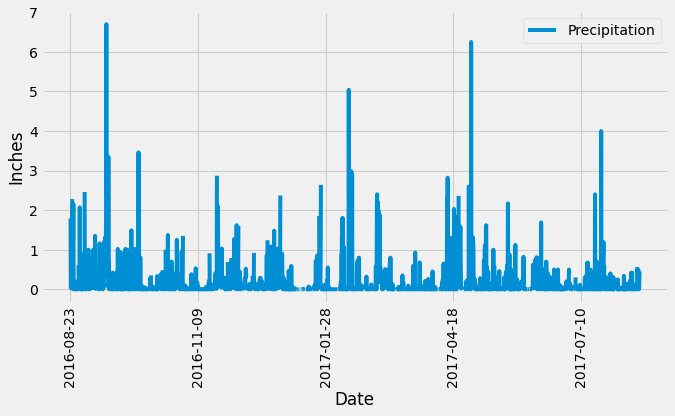

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

ax = one_yr_pcp_df.plot(rot=90, xlabel='Date', ylabel='Inches', figsize=(10, 5))
plt.legend(['Precipitation'])

plt.show()

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_yr_pcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
total_num_station = session.query(Measurment.station).distinct().count()
total_num_station

9

In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count_list = session.query(Measurment.station, func.count(Measurment.station).label('count')).\
                group_by(Measurment.station).order_by(desc('count')).all()

station_count_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(Measurment.tobs), func.max(Measurment.tobs), func.avg(Measurment.tobs)).\
             filter(Measurment.station == f'{station_count_list[0][0]}')

print(f'Minimum Temperature for Station ID: {station_count_list[0][0]} is {temp[0][0]} degree F')
print(f'Maximum Temperature for Station ID: {station_count_list[0][0]} is {temp[0][1]} degree F')
print(f'Average Temperature for Station ID: {station_count_list[0][0]} is {round(temp[0][2], 2)} degree F')

Minimum Temperature for Station ID: USC00519281 is 54.0 degree F
Maximum Temperature for Station ID: USC00519281 is 85.0 degree F
Average Temperature for Station ID: USC00519281 is 71.66 degree F


In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_yr_d_act_st = latest_date - relativedelta(months=12)

temp_data = session.query(Measurment.date, Measurment.tobs).\
            filter(Measurment.station == f'{station_count_list[0][0]}').\
            filter(Measurment.date >= one_yr_d_act_st)
            

In [42]:
temp_df = pd.read_sql(temp_data.statement, engine.connect(), index_col='date')

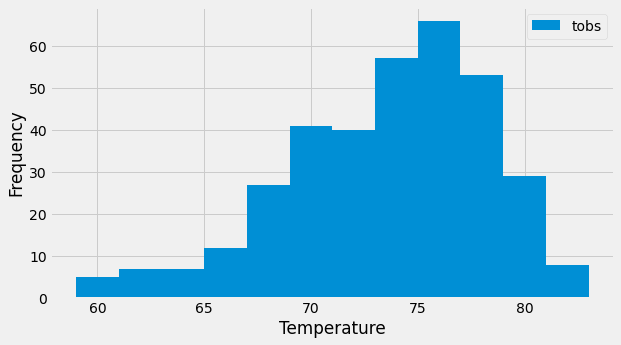

In [43]:
temp_df.plot(kind='hist', bins=12, figsize=(9,5))
plt.xlabel('Temperature')
plt.show()

# Close session

In [44]:
# Close Session
session.close()